In [1]:
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df=pd.read_csv("dataset_57_hypothyroid.csv", parse_dates=True, encoding='UTF-8',
               true_values=['t'], false_values=['f'], na_values=['?'])


In [3]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,False,False,False,False,False,False,False,False,...,True,125.0,True,1.14,True,109.0,False,NaN,SVHC,negative
1,23.0,F,False,False,False,False,False,False,False,False,...,True,102.0,False,NaN,False,NaN,False,NaN,other,negative
2,46.0,M,False,False,False,False,False,False,False,False,...,True,109.0,True,0.91,True,120.0,False,NaN,other,negative
3,70.0,F,True,False,False,False,False,False,False,False,...,True,175.0,False,NaN,False,NaN,False,NaN,other,negative
4,70.0,F,False,False,False,False,False,False,False,False,...,True,61.0,True,0.87,True,70.0,False,NaN,SVI,negative


In [4]:
df.replace("F", 0, inplace=True)
df.replace("M", 1, inplace=True)
# df.replace("negative", 1, inplace=True)
df.replace("M", 1, inplace=True)

In [5]:
pandas_profiling.ProfileReport(df)


Number of variables,30
Number of observations,3772
Total Missing (%),5.4%
Total size in memory,368.4 KiB
Average record size in memory,100.0 B
Numeric,7
Categorical,2
Boolean,18
Date,0
Text (Unique),0
Rejected,3


In [6]:
df.shape

(3772, 30)

Заполним пропуски в данных:

In [7]:
total = df.isnull().sum().sort_values(ascending=False)
total

TBG                          3772
T3                            769
T4U                           387
FTI                           385
TSH                           369
TT4                           231
sex                           150
age                             1
query_hypothyroid               0
I131_treatment                  0
thyroid_surgery                 0
pregnant                        0
on_antithyroid_medication       0
sick                            0
lithium                         0
query_on_thyroxine              0
on_thyroxine                    0
query_hyperthyroid              0
Class                           0
goitre                          0
tumor                           0
referral_source                 0
psych                           0
TSH_measured                    0
T3_measured                     0
TT4_measured                    0
T4U_measured                    0
FTI_measured                    0
TBG_measured                    0
hypopituitary 

В колонке TBG данных совсем нет, удаляем.

In [8]:
df.drop(columns=['TBG'], inplace=True)

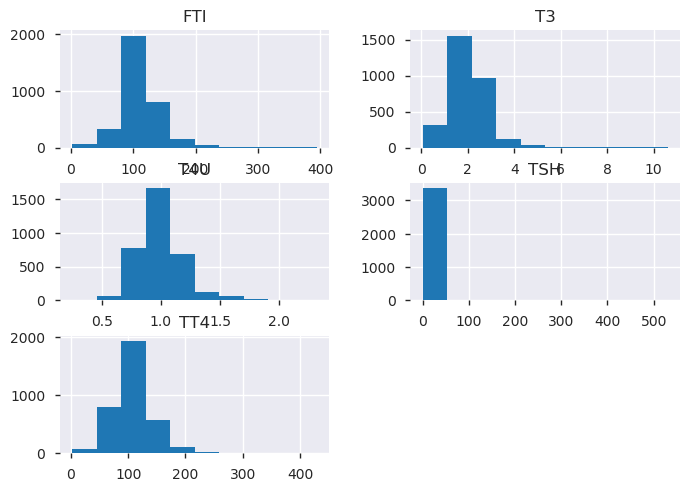

In [9]:
_ = df[['T3', 'T4U', 'FTI', 'TSH', 'TT4']].hist()

заполняем средними значениями

In [10]:
df.fillna(df.mean(), inplace=True)

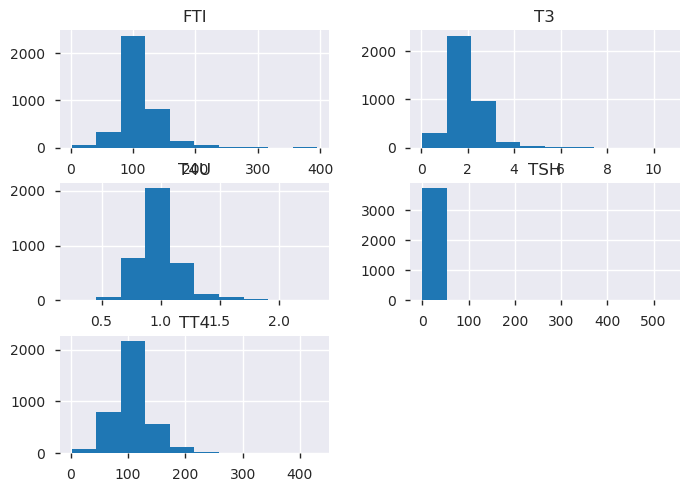

In [11]:
_ = df[['T3', 'T4U', 'FTI', 'TSH', 'TT4']].hist()

In [12]:
df['Class'].value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

из данных:

- FTI_measured сильно кореллирует с T4U_measured (ρ = 0.99712), уберём одну из анализа
- fti - normal
- class - 4 classes?
- TBG, TBG_measured - константы

FTI, T3, T4U, TSH, TT4, age


referral_source, sex - n classes

In [13]:
df.drop(columns=['TSH_measured', 'T3_measured', 'TT4_measured',
                'T4U_measured', 'FTI_measured', 'TBG_measured'],
        inplace=True)

In [14]:
numeric_columns = ['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age']


In [15]:
df = pd.concat([df,pd.get_dummies(df['referral_source'], prefix='referral_source')],axis=1)
df.drop(columns=['referral_source'], inplace=True)

In [16]:
df.replace('True', 1, inplace=True)
df.replace('False', 0, inplace=True)

## Построение моделей

In [17]:
import operator
def get_coefs(model):  
    classes = model.classes_
    coefs = model.coef_
    
    for target, coefs in zip(classes, coefs):   
        print(target)
        coefs_dict = dict(zip(X.columns, coefs))
        sorted_dict = sorted(coefs_dict.items(), key=operator.itemgetter(1), reverse=True)
        print(sorted_dict[:5])

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics


In [19]:
from sklearn.model_selection import train_test_split
y = df["Class"]
X = df.drop(columns=["Class"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df["Class"])

In [20]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(multi_class='ovr'))
y = df["Class"]
X = df.drop(columns=["Class"])
scores = cross_val_score(pipe, X, y, cv=4)
print("cv score = " + str(np.mean(scores)))


cv score = 0.946717252844774


In [21]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(metrics.classification_report(y_pred, y_test))

                         precision    recall  f1-score   support

compensated_hypothyroid       0.10      0.86      0.18         7
               negative       1.00      0.95      0.97      1095
    primary_hypothyroid       0.82      0.77      0.79        30
  secondary_hypothyroid       0.00      0.00      0.00         0

            avg / total       0.99      0.95      0.96      1132



In [22]:
get_coefs(pipe.named_steps['logisticregression'])

compensated_hypothyroid
[('query_hypothyroid', 0.2785047215741229), ('psych', 0.12502754991938528), ('query_on_thyroxine', 0.11874392824620146), ('tumor', 0.1106640872810389), ('referral_source_other', 0.08041407353717246)]
negative
[('on_thyroxine', 3.477446402276038), ('thyroid_surgery', 0.7938830072384576), ('FTI', 0.7381915660482052), ('T3', 0.483434213298251), ('sex', 0.3180260962529947)]
primary_hypothyroid
[('TSH', 1.321401654916879), ('T4U', 0.46440759805185644), ('referral_source_STMW', 0.177436402046046), ('tumor', 0.1309812730239539), ('age', 0.10929693211306095)]
secondary_hypothyroid
[('referral_source_other', 0.07650873139815095), ('pregnant', 0.019444225862325727), ('referral_source_STMW', 0.016414501435959513), ('referral_source_SVHD', -0.00033182874350159514), ('psych', -0.0014465454193830758)]


In [23]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced'))
y = df["Class"]
X = df.drop(columns=["Class"])
scores = cross_val_score(pipe, X, y, cv=4)
print("cv score = " + str(np.mean(scores)))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(metrics.classification_report(y_pred, y_test, ))

cv score = 0.9602334673168994
                         precision    recall  f1-score   support

compensated_hypothyroid       0.93      0.68      0.79        79
               negative       0.96      1.00      0.98      1010
    primary_hypothyroid       0.89      0.71      0.79        35
  secondary_hypothyroid       0.00      0.00      0.00         8

            avg / total       0.95      0.96      0.95      1132



In [24]:
get_coefs(pipe.named_steps['logisticregression'])

compensated_hypothyroid
[('TSH', 6.079068017992747), ('TT4', 1.430249737416517), ('FTI', 0.9599280005833795), ('T3', 0.6377120844855165), ('sex', 0.45396524162068075)]
negative
[('on_thyroxine', 3.10668872257192), ('FTI', 1.5670556641585132), ('TT4', 1.3257508264239577), ('T3', 0.9822352445026687), ('thyroid_surgery', 0.9252674534830345)]
primary_hypothyroid
[('TSH', 6.3179754303150215), ('T4U', 1.4048931798560802), ('referral_source_STMW', 0.5459118356114704), ('referral_source_SVI', 0.48613406648447877), ('sex', 0.2443715268141853)]
secondary_hypothyroid
[('referral_source_other', 1.1427627602676065), ('on_antithyroid_medication', 0.006633980948995985), ('hypopituitary', -0.0011854572195648388), ('referral_source_STMW', -0.005344359352946755), ('lithium', -0.006719619662580015)]


In [25]:
from sklearn.model_selection import GridSearchCV
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
pipe = make_pipeline(StandardScaler(), LogisticRegression(multi_class='ovr', solver='lbfgs', class_weight='balanced'))
y = df["Class"]
X = df.drop(columns=["Class"])
                                                          
grid = GridSearchCV(estimator=pipe, param_grid=dict(logisticregression__C=Cs), cv=4, n_jobs=2, verbose=True)
_ = grid.fit(X_train, y_train) 

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=2)]: Done  28 out of  28 | elapsed:    1.1s finished


In [26]:
print(str(max(grid.cv_results_['mean_test_score'])))

0.9621212121212122


In [27]:
y_pred = grid.best_estimator_.predict(X_test)
print(metrics.classification_report(y_pred, y_test))

                         precision    recall  f1-score   support

compensated_hypothyroid       0.81      0.66      0.73        71
               negative       0.97      0.99      0.98      1024
    primary_hypothyroid       0.82      0.70      0.75        33
  secondary_hypothyroid       0.00      0.00      0.00         4

            avg / total       0.95      0.96      0.95      1132



In [28]:
get_coefs(grid.best_estimator_.named_steps['logisticregression'])

compensated_hypothyroid
[('TSH', 2.303357828351072), ('query_hypothyroid', 0.19717185808108978), ('T4U', 0.19336519612822173), ('psych', 0.13615521382949758), ('tumor', 0.09743132401672623)]
negative
[('on_thyroxine', 11.828167178254901), ('goitre', 4.486505286784589), ('on_antithyroid_medication', 3.174846223106916), ('pregnant', 3.1591645536678823), ('thyroid_surgery', 2.794419821050835)]
primary_hypothyroid
[('TSH', 5.253969626395688), ('T4U', 0.684063097093817), ('referral_source_STMW', 0.6570630499885529), ('referral_source_SVI', 0.28881444415443247), ('referral_source_SVHC', 0.18998303426474306)]
secondary_hypothyroid
[('TT4', 15.657568895781823), ('referral_source_other', 8.7476327062022), ('referral_source_STMW', 0.10876142058109158), ('pregnant', 0.04914306089110161), ('referral_source_SVHC', 0.04747991739744124)]


Oversampling:

In [29]:
from imblearn import over_sampling
oversampler = over_sampling.RandomOverSampler()
X_sm, y_sm = oversampler.fit_sample(X, y)

In [30]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(multi_class='ovr', solver='lbfgs'))
scores = cross_val_score(pipe, X_sm, y_sm, cv=4)
print("cv score = " + str(np.mean(scores)))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(metrics.classification_report(y_pred, y_test, ))

cv score = 0.9207120894202727
                         precision    recall  f1-score   support

compensated_hypothyroid       0.16      0.82      0.26        11
               negative       1.00      0.95      0.97      1095
    primary_hypothyroid       0.79      0.85      0.81        26
  secondary_hypothyroid       0.00      0.00      0.00         0

            avg / total       0.98      0.95      0.96      1132

